In [1]:
import pandas as pd
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
import numpy as np
from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import SGD
from matplotlib import pyplot
from scipy.stats import spearmanr
from scipy.stats import pearsonr
import keras.backend as K
from sklearn.datasets import make_regression
from sklearn.preprocessing import StandardScaler
import keras

Using TensorFlow backend.


Here you see how to calculate the spearman correlation using numpy (1a), tensors (1b) and scipy.stats.spearmanr (3).
The results are similar. The comparison is in 3.
See: https://archive.md/VfNkG

In [2]:
#1a spearman from scratch using numpy
def spearman_correlation(predictions, targets):
    if not isinstance(predictions, pd.Series):
        predictions = pd.Series(predictions)
    ranked_preds = predictions.rank(pct = True, method = "first")
    return np.corrcoef(ranked_preds, targets)[0, 1]

#2a spearman from scratch using tensors
def corrcoef(x, y):

    mx = tf.math.reduce_mean(x)
    my = tf.math.reduce_mean(y)
    xm, ym = x - mx, y - my
    r_num = tf.math.reduce_sum(xm * ym)
    r_den = tf.norm(xm) * tf.norm(ym)
    return r_num / (r_den + tf.keras.backend.epsilon())

#2b. spearman using tensors
def tf_spearman_correlation(predictions, targets):
    ranked_preds = tf.cast(tf.argsort(tf.argsort(predictions, stable = True)), targets.dtype)
    return corrcoef(ranked_preds, targets)

targets = np.array([0.0, 0.25, 0.5, 0.75, 1.0], dtype = np.float32)
predictions = np.random.rand(targets.shape[0])

print("numpy spearman:", spearman_correlation(predictions, targets))
result = tf_spearman_correlation(tf.convert_to_tensor(predictions, dtype=tf.float32), tf.convert_to_tensor(targets, dtype=tf.float32))
with tf.Session() as sess:
    scalar = result.eval()

    
#COMPARISON

print("tf spearman", scalar)
#3
print (spearmanr(targets,predictions))  #spearman using scipy stats

numpy spearman: 0.19999999999999993
tf spearman 0.2
SpearmanrResult(correlation=0.19999999999999998, pvalue=0.747060078104662)


Next we use tensors to program a spearman loss. Note the argsort operation in line 7, which is not differentiable. 
If you tell Keras to use this spearman_loss, it will complain about the lack of a gradient. So spearman_loss cannot be used.  The ranking step needs to substituted by a tensor operation that is similar enough and yet differentiable not available in tf 1.5.
IMPORTANT: in any case, if you want to use spearman_loss you want to use penalized_pearson_loss to make sure that it converges with the mse (see 5.pearson_corr.ipynb)

In [3]:
def spearman_loss(y_true, y_pred, axis=-2):
#Generates an error due to ranking operation not being differentiable do not use
    """Spearman correlation coefficient using tensors"""

    x = y_true
    y = y_pred
    y = tf.cast(tf.argsort(tf.argsort(y, stable = True)), targets.dtype) #argsort is not a differentiable operation
    xm, ym = x - K.mean(x), y - K.mean(y)
    r_num = K.sum(tf.multiply(xm, ym))
    r_den = K.sqrt(tf.multiply(K.sum(K.square(xm)), K.sum(K.square(ym))))
    r = r_num / (r_den + K.epsilon())
    r = K.maximum(K.minimum(r, 1.0), -1.0)
    
    ysqsum = K.sum(K.square(ym))
    n = tf.cast(tf.shape(x)[axis], x.dtype)
    sqdif = tf.reduce_sum(tf.math.squared_difference(x, y), axis=axis) / n / tf.sqrt(ysqsum / n)

    return  tf.convert_to_tensor(tf.constant(1.0, dtype=x.dtype) - K.square(r)  + (0.01 * sqdif))

def penalized_spearman_loss(x,y, axis=-2):
    """Penalized Spearman correlation coefficient"""
    x = tf.convert_to_tensor(x)
    y = tf.cast(tf.argsort(tf.argsort(y, stable = True)), targets.dtype) #argsort is not a differentiable operation
    #y = K.cast(y, x.dtype)
    n = tf.cast(tf.shape(x)[axis], x.dtype)
    xsum = tf.reduce_sum(x, axis=axis)
    ysum = tf.reduce_sum(y, axis=axis)
    xmean = xsum / n
    ymean = ysum / n
    xsqsum = tf.reduce_sum( tf.math.squared_difference(x, xmean), axis=axis)
    ysqsum = tf.reduce_sum( tf.math.squared_difference(y, ymean), axis=axis)
    cov = tf.reduce_sum( (x - xmean) * (y - ymean), axis=axis)
    corr = cov / (tf.sqrt(xsqsum * ysqsum)+ K.epsilon())
    sqdif = tf.reduce_sum(tf.math.squared_difference(x, y), axis=axis) / n / tf.sqrt(ysqsum / n)
    return tf.convert_to_tensor( K.mean(tf.constant(1.0, dtype=x.dtype) - corr + (0.01 * sqdif)) , dtype=tf.float32 )

Next we use tensors to program a spearman metric. Note the use of py_func (a shortcut).

py_func is a tf wrapper for a python function. py_func returns a tensor.
Below we use py_func to wrap around the python function spearmanr.
This use of py_func works in my setup but it does not always work.
If you have problems with it, 
just use the spearman_metric underneath (commented out) that uses tensors.

In [4]:
def spearman_metric(y_true, y_pred):
    """Spearman correlation coefficient using a tf wrapper for a python function"""

    r = tf.py_function(spearmanr, inp=[y_true, y_pred], Tout=tf.float32)
    
    return  tf.constant(1.0, dtype=y_true.dtype) - r

def spearman_metric(y_true, y_pred):
    """Spearman correlation coefficient using tensors"""

    x = y_true
    y = y_pred
    y = tf.cast(tf.argsort(tf.argsort(y, stable = True)), targets.dtype)
    xm, ym = x - K.mean(x), y - K.mean(y)
    r_num = K.sum(tf.multiply(xm, ym))
    r_den = K.sqrt(tf.multiply(K.sum(K.square(xm)), K.sum(K.square(ym))))
    r = r_num / (r_den + K.epsilon())
    r = K.maximum(K.minimum(r, 1.0), -1.0)

    return  tf.constant(1.0, dtype=x.dtype) - K.square(r)

In [5]:
num_features = 20
# generate regression dataset
X, y = make_regression(n_samples=1000, n_features=num_features, noise=0.1, random_state=1)

# split into train and test
n_train = 500
trainX, testX = X[:n_train, :], X[n_train:, :]
trainy, testy = y[:n_train], y[n_train:]

# reshape 1d arrays to 2d arrays
trainy = trainy.reshape(len(trainy), 1)
testy = testy.reshape(len(trainy), 1)

# create scaler
scaler = StandardScaler()
# fit scaler on training dataset
scaler.fit(trainy)
# transform training dataset
trainy = scaler.transform(trainy)
# transform test dataset
testy = scaler.transform(testy)

# fit scaler on training dataset
scaler.fit(trainX)
# transform training dataset
trainX = scaler.transform(trainX)
# transform test dataset
testX = scaler.transform(testX)

Train on 500 samples, validate on 500 samples
Epoch 1/100
500/500 [==============================] - 0s 582us/step - loss: 1.4626 - spearman_metric: 0.8298 - val_loss: 0.6984 - val_spearman_metric: 0.3483
Epoch 2/100
500/500 [==============================] - 0s 132us/step - loss: 0.3686 - spearman_metric: 0.2206 - val_loss: 0.2664 - val_spearman_metric: 0.1081
Epoch 3/100
500/500 [==============================] - 0s 97us/step - loss: 0.1954 - spearman_metric: 0.1091 - val_loss: 0.1742 - val_spearman_metric: 0.0771
Epoch 4/100
500/500 [==============================] - 0s 97us/step - loss: 0.1227 - spearman_metric: 0.0755 - val_loss: 0.1404 - val_spearman_metric: 0.0632
Epoch 5/100
500/500 [==============================] - 0s 94us/step - loss: 0.0950 - spearman_metric: 0.0554 - val_loss: 0.1320 - val_spearman_metric: 0.0502
Epoch 6/100
500/500 [==============================] - 0s 100us/step - loss: 0.0807 - spearman_metric: 0.0460 - val_loss: 0.1077 - val_spearman_metric: 0.0489
Epo

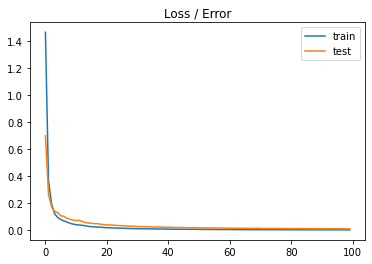

In [6]:
# mlp with scaled outputs on the regression problem with custom loss and custom metric
# define model
model = Sequential()
model.add(Dense(25, input_dim=20, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(1, activation='linear'))
# compile model using as loss: 'mean_squared_error', and as metric: spearman_metric
#model.compile(loss=spearman_loss, optimizer=SGD(lr=0.01, momentum=0.9), metrics=[spearman_metric]) #no gradient for spearman_loss, cannot use
model.compile(loss='mean_squared_error', optimizer=SGD(lr=0.01, momentum=0.9), metrics=[spearman_metric])
#model.compile(loss='mean_squared_error', optimizer=SGD(lr=0.01, momentum=0.9))
# fit model
history = model.fit(trainX, trainy, validation_data=(testX, testy), epochs=100, verbose=1)
# evaluate the model
train_e = model.evaluate(trainX, trainy, verbose=1)
test_e = model.evaluate(testX, testy, verbose=1)
print('Train loss: %.3f, Test loss: %.3f' % (train_e[0], test_e[0])) #when using custom loss and custom metric
print('Train metric: %.3f, Test metric: %.3f' % (train_e[1], test_e[1])) #when using custom loss and custom metric
#print('Train loss: %.3f, Test loss: %.3f' % (train_e, test_e)) 
#plot loss during training
pyplot.title('Loss / Error')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

Does Keras use metric functions (including custom metric functions) for anything other than reporting?
You can use a metric function in a callback to make Keras stop training when the metric function's score
is no longer improving.
See:
https://archive.md/OLvkZ
https://archive.md/VTS87
https://archive.md/RV8A8